In [339]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
import re
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

## Chargement Dataset

In [340]:
df = pd.read_csv("data/train_tweets.csv")

## Apercu des valeurs 

In [341]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [342]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [343]:
print(df.shape)

(7613, 5)


In [344]:
df.dropna(inplace=True)

## EDA sur données bruts


In [345]:
df_0 = df[df['target'] == 0]
df_1 = df[df['target'] == 1]

In [346]:
# Fonction pour obtenir les mots les plus fréquents
def get_top_words(series, n=10):
    words = " ".join(series).lower().split()
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return Counter(words).most_common(n)


# Extraction des top mots
top_words_0 = get_top_words(df_0["keyword"], 50)
top_words_1 = get_top_words(df_1["keyword"], 50)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Keyword (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Keyword (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Keyword (Non-catastrophe),Fréquence,Keyword (Catastrophe),Fréquence
0,armageddon,28,outbreak,30
1,ruin,27,wreckage,28
2,harm,26,oil%20spill,27
3,aftershock,25,collision,26
4,bloody,25,buildings%20on%20fire,25
5,fear,25,derailment,25
6,screaming,25,evacuated,25
7,upheaval,25,airplane%20accident,24
8,blight,24,earthquake,24
9,deluge,24,sandstorm,24


In [347]:
# Extraction des top mots
top_words_0 = get_top_words(df_0["location"], 50)
top_words_1 = get_top_words(df_1["location"], 50)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Location (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Location (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Location (Non-catastrophe),Fréquence,Location (Catastrophe),Fréquence
0,new,129,usa,126
1,usa,124,new,80
2,ca,86,ca,57
3,york,77,united,44
4,london,52,nigeria,42
5,united,51,canada,41
6,uk,49,uk,40
7,ny,46,india,34
8,england,44,san,33
9,canada,43,states,33


In [348]:


# Extraction des top mots
top_words_0 = get_top_words(df_0["text"], 50)
top_words_1 = get_top_words(df_1["text"], 50)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Mot (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Mot (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Mot (Non-catastrophe),Fréquence,Mot (Catastrophe),Fréquence
0,-,259,-,244
1,like,165,&amp;,74
2,just,154,police,72
3,i'm,141,like,65
4,new,127,just,61
5,&amp;,119,killed,60
6,??,115,families,59
7,it's,79,people,57
8,don't,75,suicide,57
9,|,75,...,56


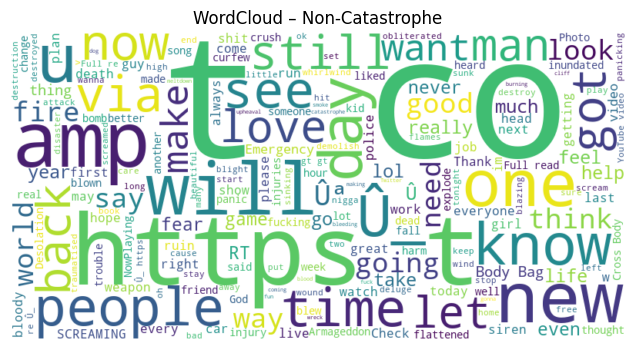

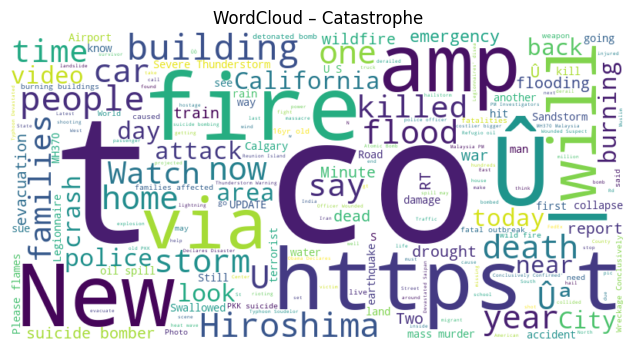

In [349]:
# Concaténer les textes par classe
text_0 = " ".join(df_0["text"])
text_1 = " ".join(df_1["text"])

# Générer les nuages de mots
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Affichage du WordCloud pour target = 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Affichage du WordCloud pour target = 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()

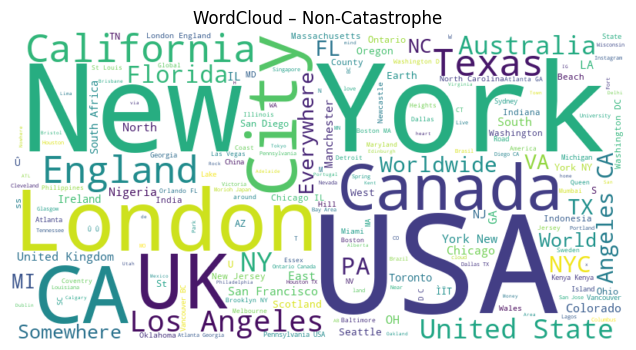

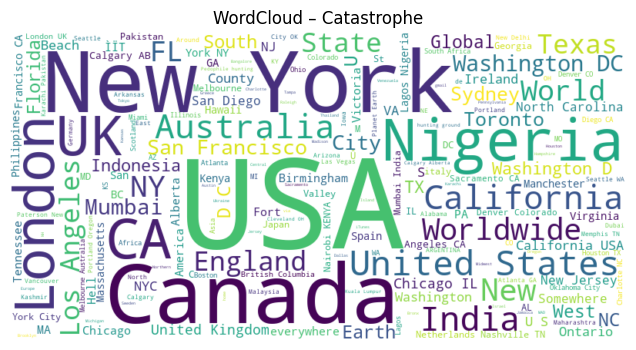

In [350]:
# Concaténer les textes par classe
text_0 = " ".join(df_0["location"])
text_1 = " ".join(df_1["location"])

# Générer les nuages de mots
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Affichage du WordCloud pour target = 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Affichage du WordCloud pour target = 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()


## Ajout features

In [351]:
# Nombre de caractères par tweet
df['char_count'] = df['text'].apply(len)

# Nombre de mots par tweet
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Nb de stop-words
df["stopword_count"] = df["text"].apply(
    lambda x: sum(1 for w in x.lower().split() if w in ENGLISH_STOP_WORDS)
)



## Analyse des features

In [352]:
# Statistiques descriptives
df[['char_count', 'word_count', 'stopword_count']].describe()

,char_count,word_count,stopword_count
count,5080.000000,5080.000000,5080.000000
mean,102.319882,15.088780,5.014370
std,33.405894,5.680351,3.596501
min,8.000000,1.000000,0.000000
25%,79.000000,11.000000,2.000000
50%,109.000000,15.000000,4.000000
75%,134.000000,19.000000,7.000000
max,152.000000,30.000000,20.000000


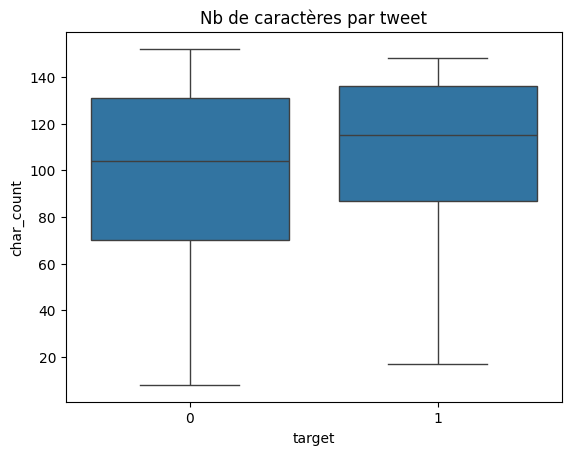

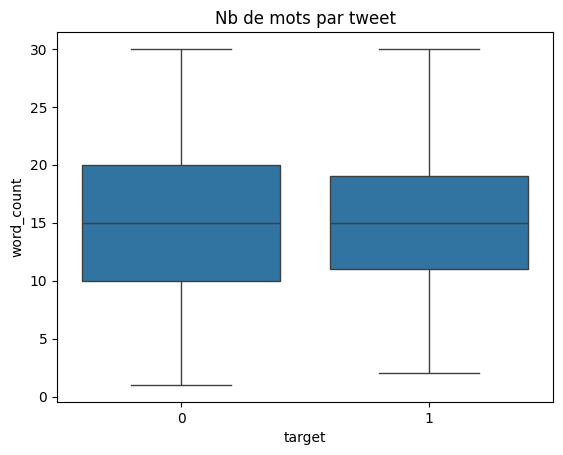

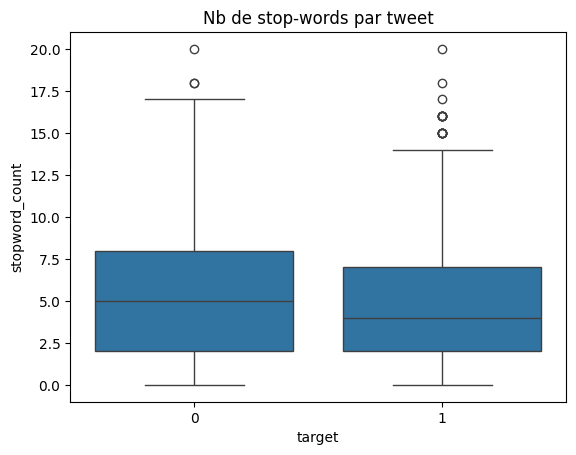

In [353]:
# Taille des tweets (caractères)
sns.boxplot(data=df, x="target", y="char_count")
plt.title("Nb de caractères par tweet")
plt.show()

# Taille des tweets (mots)
sns.boxplot(data=df, x="target", y="word_count")
plt.title("Nb de mots par tweet")
plt.show()

# Nombre de stopwords
sns.boxplot(data=df, x="target", y="stopword_count")
plt.title("Nb de stop-words par tweet")
plt.show()

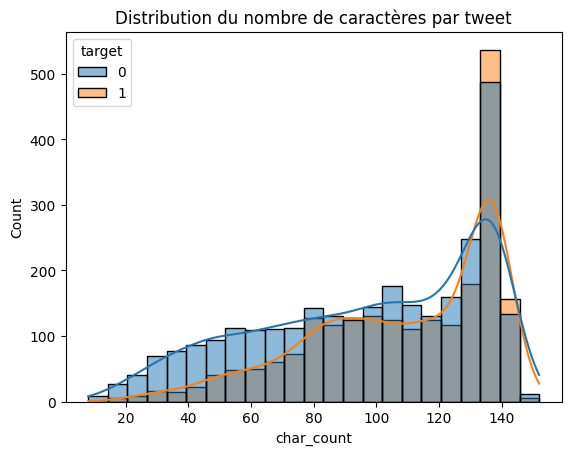

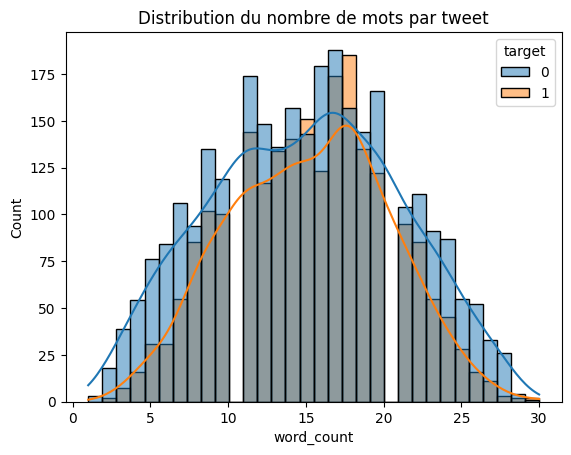

In [354]:


sns.histplot(data=df, x='char_count', hue='target', kde=True)
plt.title("Distribution du nombre de caractères par tweet")
plt.show()

sns.histplot(data=df, x='word_count', hue='target', kde=True)
plt.title("Distribution du nombre de mots par tweet")
plt.show()




# Traitement des valeurs nuls ou non pertinentes

In [355]:
df.drop(columns=['id','location'], inplace=True)
df.drop_duplicates(inplace=True)


In [356]:
print(df.shape)

(5048, 6)


In [357]:
df.dropna(inplace=True)
print(df.shape) 
df.info()

(5048, 6)
<class 'pandas.core.frame.DataFrame'>
Index: 5048 entries, 31 to 7581
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   keyword         5048 non-null   object
 1   text            5048 non-null   object
 2   target          5048 non-null   int64 
 3   char_count      5048 non-null   int64 
 4   word_count      5048 non-null   int64 
 5   stopword_count  5048 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 276.1+ KB


In [358]:
df.head()

,keyword,text,target,char_count,word_count,stopword_count
31,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,5,0
32,ablaze,We always try to bring the heavy. #metal #RT h...,0,67,10,4
33,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,9,1
34,ablaze,Crying out for more! Set me ablaze,0,34,7,3
35,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76,13,7


In [359]:
df['target'].value_counts(normalize=True)

target
0    0.569532
1    0.430468
Name: proportion, dtype: float64

# Proportion target

In [360]:

df_0 = df[df['target'] == 0]
df_1 = df[df['target'] == 1]

# 2. Échantillonner aléatoirement la classe 0 pour avoir autant d'exemples que la classe 1
df_0_sampled = df_0.sample(n=len(df_1), random_state=42)

df_balanced = pd.concat([df_0_sampled, df_1], axis=0).sample(frac=1, random_state=42)  # shuffle le tout


In [361]:

df_balanced['target'].value_counts(normalize=True)

target
1    0.5
0    0.5
Name: proportion, dtype: float64

In [362]:
df_balanced['keyword'].value_counts()


keyword
collision                31
whirlwind                30
outbreak                 30
sandstorm                30
derailed                 29
                         ..
razed                     8
detonation                8
epicentre                 8
radiation%20emergency     6
inundation                4
Name: count, Length: 221, dtype: int64

# Analyse de notre dataset


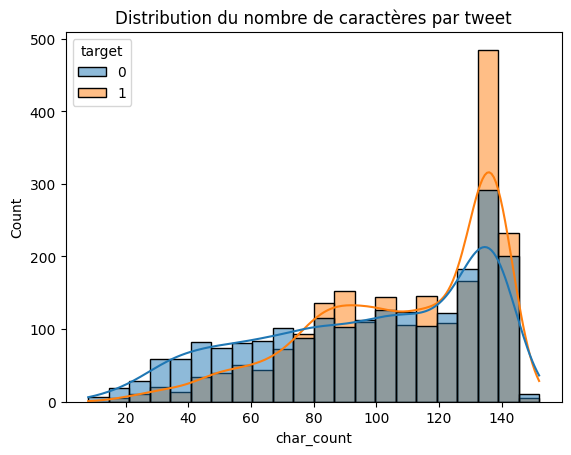

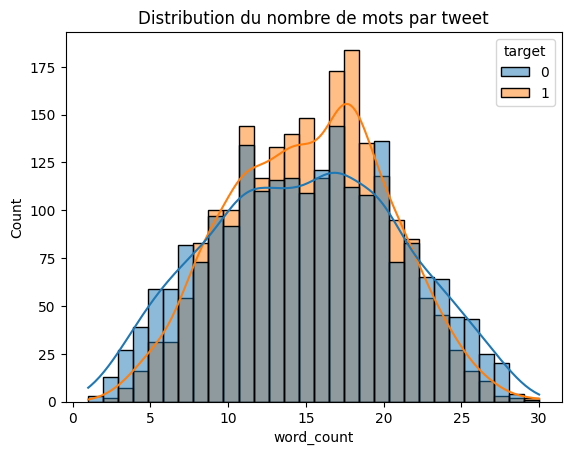

In [363]:


sns.histplot(data=df_balanced, x='char_count', hue='target', kde=True)
plt.title("Distribution du nombre de caractères par tweet")
plt.show()

sns.histplot(data=df_balanced, x='word_count', hue='target', kde=True)
plt.title("Distribution du nombre de mots par tweet")
plt.show()


1. Distribution du nombre de caractères par tweet


La majorité des tweets sont entre 80 et 140 caractères.
Les tweets de catastrophe sont en moyenne plus longs.
Il y a un pic brutal à ~140 caractères pour les deux classes.
Les tweets catastrophes sont surement plus détaillés, plus descriptifs, ce qui donne une longueur moyenne plus élevée.


2. Distribution du nombre de mots par tweet

Les tweets catastrophes contiennent un peu plus de mots que les autres.
Le pic est autour de 14-18 mots pour les catastrophes, un peu plus bas pour les autres.


3. Interprétation globale : 

L’EDA montre que les tweets liés à des catastrophes réelles sont généralement un peu plus longs que les tweets non-catastrophes, à la fois en nombre de caractères et de mots. Cela reflète sans doute leur nature plus factuelle, urgente ou descriptive (ex : rapports d’incidents, alertes, témoignages). Cependant, les distributions restent proches : la longueur seule ne suffit pas à distinguer les classes, mais elle peut constituer un indice utile combiné à d'autres features (mots, n-grammes, keyword, etc.).

## Nettoyage

Passage en miniscule

In [364]:
df_balanced['text'] = df_balanced['text'].str.lower()
df_balanced['keyword'] = df_balanced['keyword'].str.lower()

In [365]:
df_balanced.head()

,keyword,text,target,char_count,word_count,stopword_count
3021,dust%20storm,wall of noise is one thing - but a wall of dus...,1,138,23,11
1331,burning%20buildings,mmmmmm i'm burning.... i'm burning buildings i...,0,84,11,0
4085,hail,@kmactwn @meaganerd looks like a bowl of weath...,0,113,18,4
773,blew%20up,lmao that light skin guy blew up on twitter by...,0,87,19,10
6627,terrorism,cross-border terrorism: pakistan caught red-ha...,1,100,12,3


Suppression liens /mentions / hashtags / ponctuation/chiffres

Suppression des stopwords et vectorisation


In [366]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)      # URLs
    text = re.sub(r"@\w+|#\w+", "", text)           # Mentions & hashtags
    text = re.sub(r"[^a-z\s]", "", text)            # Ponctuation / chiffres
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Nettoyage de base
df_balanced["clean_text"] = df_balanced["text"].apply(clean_text)

# Tokenisation X
df_balanced["tokens"] = df_balanced["clean_text"].apply(lambda x: x.split())

# Suppression des stopwords
df_balanced["tokens"] = df_balanced["tokens"].apply(lambda tokens: [w for w in tokens if w not in stop_words])  


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sulivanmoreau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Application 

In [367]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()


# Version 2 : Stopwords uniquement
df_balanced["version_stop"] = df_balanced["tokens"].apply(lambda x: " ".join(x))

# Version 3 : Stemming
df_balanced["version_stem"] = df_balanced["tokens"].apply(
    lambda tokens: " ".join([stemmer.stem(t) for t in tokens])
)

# Version 4 : Lemmatization
df_balanced["version_lemma"] = df_balanced["tokens"].apply(
    lambda tokens: " ".join([lemmatizer.lemmatize(t) for t in tokens])
)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sulivanmoreau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sulivanmoreau/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sulivanmoreau/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [368]:
df_balanced.head()

,keyword,text,target,char_count,word_count,stopword_count,clean_text,tokens,version_stop,version_stem,version_lemma
3021,dust%20storm,wall of noise is one thing - but a wall of dus...,1,138,23,11,wall of noise is one thing but a wall of dust ...,"[wall, noise, one, thing, wall, dust, moving, ...",wall noise one thing wall dust moving mph get ...,wall nois one thing wall dust move mph get blo...,wall noise one thing wall dust moving mph get ...
1331,burning%20buildings,mmmmmm i'm burning.... i'm burning buildings i...,0,84,11,0,mmmmmm im burning im burning buildings im buil...,"[mmmmmm, im, burning, im, burning, buildings, ...",mmmmmm im burning im burning buildings im buil...,mmmmmm im burn im burn build im build oooooohh...,mmmmmm im burning im burning building im build...
4085,hail,@kmactwn @meaganerd looks like a bowl of weath...,0,113,18,4,looks like a bowl of weather cereal new kellog...,"[looks, like, bowl, weather, cereal, new, kell...",looks like bowl weather cereal new kelloggs su...,look like bowl weather cereal new kellogg suga...,look like bowl weather cereal new kellogg suga...
773,blew%20up,lmao that light skin guy blew up on twitter by...,0,87,19,10,lmao that light skin guy blew up on twitter by...,"[lmao, light, skin, guy, blew, twitter, talkin...",lmao light skin guy blew twitter talking ugly kid,lmao light skin guy blew twitter talk ugli kid,lmao light skin guy blew twitter talking ugly kid
6627,terrorism,cross-border terrorism: pakistan caught red-ha...,1,100,12,3,crossborder terrorism pakistan caught redhande...,"[crossborder, terrorism, pakistan, caught, red...",crossborder terrorism pakistan caught redhande...,crossbord terror pakistan caught redhand time ...,crossborder terrorism pakistan caught redhande...


In [369]:
clean_df_0 = df_balanced[df_balanced['target'] == 0]
clean_df_1 = df_balanced[df_balanced['target'] == 1]

# Analyse de la récurrence des mots les plus fréquents

In [370]:
# Fonction pour obtenir les mots les plus fréquents
def get_top_words(series, n=10):
    words = " ".join(series).lower().split()
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return Counter(words).most_common(n)

# Séparation des tweets selon la cible
clean_df_0 = df_balanced[df_balanced['target'] == 0]
clean_df_1 = df_balanced[df_balanced['target'] == 1]

# Extraction des top mots
top_words_0 = get_top_words(clean_df_0["clean_text"], 10)
top_words_1 = get_top_words(clean_df_1["clean_text"], 10)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Mot (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Mot (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Mot (Non-catastrophe),Fréquence,Mot (Catastrophe),Fréquence
0,im,133,police,80
1,like,131,amp,74
2,just,124,disaster,66
3,new,104,like,65
4,amp,95,people,65
5,dont,67,just,63
6,body,56,buildings,62
7,emergency,52,pm,62
8,people,50,killed,60
9,video,50,california,60


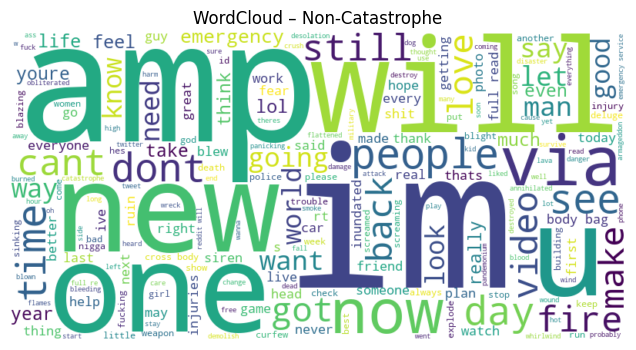

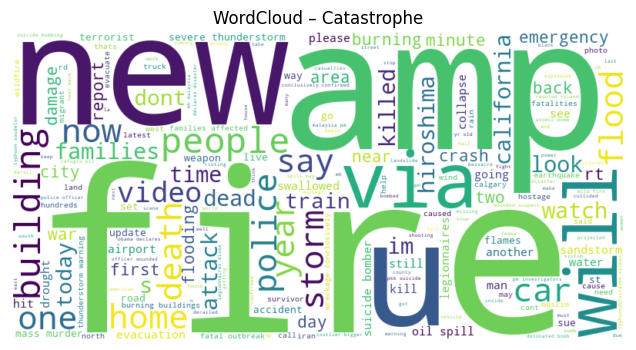

In [371]:
# Concaténer les textes par classe
text_0 = " ".join(clean_df_0["clean_text"])
text_1 = " ".join(clean_df_1["clean_text"])

# Générer les nuages de mots
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Affichage du WordCloud pour target = 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Affichage du WordCloud pour target = 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()
